# <center>Visualisation Code Challenge - COVID-19 Statistics Viz</center>

### Challenge Requirements

* Pick 5 countries
* Compare the cumulative number of COVID-19 cases against each other
* Start from the day when the first new case(s) were found in each country - day 1
* Plot the consecutive 30-day cases since day 1 for all 5 countries on the same figure
* y axis: cumulative cases per 1M population
* Goal: clearly show the growth trend of emgering cases for each country since day 1

In [1]:
import findspark
import os

findspark.init(os.environ['SPARK_HOME'])

In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
spark = SparkSession.builder.appName('visualisation').getOrCreate()

In [5]:
df = spark.read.csv('../data/WHO-COVID-19-global-data.csv', header=True, sep=',', inferSchema=True)

In [6]:
df.count()
print(df.printSchema())

root
 |-- Date_reported: timestamp (nullable = true)
 |-- Country_code: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- WHO_region: string (nullable = true)
 |-- New_cases: integer (nullable = true)
 |-- Cumulative_cases: integer (nullable = true)
 |-- New_deaths: integer (nullable = true)
 |-- Cumulative_deaths: integer (nullable = true)

None


In [7]:
df.show(5)

+-------------------+------------+-----------+----------+---------+----------------+----------+-----------------+
|      Date_reported|Country_code|    Country|WHO_region|New_cases|Cumulative_cases|New_deaths|Cumulative_deaths|
+-------------------+------------+-----------+----------+---------+----------------+----------+-----------------+
|2020-02-24 11:00:00|          AF|Afghanistan|      EMRO|        1|               1|         0|                0|
|2020-02-25 11:00:00|          AF|Afghanistan|      EMRO|        0|               1|         0|                0|
|2020-02-26 11:00:00|          AF|Afghanistan|      EMRO|        0|               1|         0|                0|
|2020-02-27 11:00:00|          AF|Afghanistan|      EMRO|        0|               1|         0|                0|
|2020-02-28 11:00:00|          AF|Afghanistan|      EMRO|        0|               1|         0|                0|
+-------------------+------------+-----------+----------+---------+----------------+----

In [8]:
df = df.withColumn('Date_reported', F.to_date(F.col('Date_reported'))) \
       .select(['Date_reported', 'Country', 'Cumulative_cases']).cache()

In [9]:
df.printSchema()

root
 |-- Date_reported: date (nullable = true)
 |-- Country: string (nullable = true)
 |-- Cumulative_cases: integer (nullable = true)



#### Get the first month of COVID-19 for each selected country

In [10]:
from datetime import timedelta

In [11]:
countries = ('China', 'Republic of Korea', 'Japan', 'Australia', 
             'United States of America', 'The United Kingdom')

In [12]:
calc_enddate = F.udf(lambda x: x + timedelta(days=29), T.DateType())

In [13]:
df_start_end = df.where(f"Country IN {countries}") \
                 .groupBy('Country').agg(F.min(F.col('Date_reported')).alias('Start_date')) \
                 .withColumn('End_date', calc_enddate(F.col('Start_date')))

df_start_end.show(truncate=False)

+------------------------+----------+----------+
|Country                 |Start_date|End_date  |
+------------------------+----------+----------+
|Republic of Korea       |2020-01-19|2020-02-17|
|China                   |2020-01-11|2020-02-09|
|United States of America|2020-01-20|2020-02-18|
|The United Kingdom      |2020-01-31|2020-02-29|
|Japan                   |2020-01-14|2020-02-12|
|Australia               |2020-01-25|2020-02-23|
+------------------------+----------+----------+



In [14]:
df = df.join(df_start_end, how='inner', on='Country') \
       .where("Date_reported <= End_date") \
       .select(['Country', 'Date_reported', 'Cumulative_cases']) \
       .sort(['Country', 'Date_reported'])
df.show(5)

+---------+-------------+----------------+
|  Country|Date_reported|Cumulative_cases|
+---------+-------------+----------------+
|Australia|   2020-01-25|               3|
|Australia|   2020-01-26|               4|
|Australia|   2020-01-27|               5|
|Australia|   2020-01-28|               5|
|Australia|   2020-01-29|               7|
+---------+-------------+----------------+
only showing top 5 rows



#### Clean [Population data](https://data.worldbank.org/indicator/SP.POP.TOTL)

In [15]:
import pandas as pd

In [16]:
pop_pd = pd.read_excel('../data/world-population.xls', sheet_name='Data')

In [17]:
pop_pd.head()

,Data Source,World Development Indicators,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64
0,Last Updated Date,2022-04-08 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Country Name,Country Code,Indicator Name,Indicator Code,1960.0,1961.0,1962.0,1963.0,1964.0,1965.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
3,Aruba,ABW,"Population, total",SP.POP.TOTL,54208.0,55434.0,56234.0,56699.0,57029.0,57357.0,...,102050.0,102565.0,103165.0,103776.0,104339.0,104865.0,105361.0,105846.0,106310.0,106766.0
4,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130836765.0,134159786.0,137614644.0,141202036.0,144920186.0,148769974.0,...,532760424.0,547482863.0,562601578.0,578075373.0,593871847.0,609978946.0,626392880.0,643090131.0,660046272.0,677243299.0


In [18]:
# drop irrelevant columns
pop_pd = pop_pd[2:].copy().drop(
    ['World Development Indicators', 'Unnamed: 2', 'Unnamed: 3'],
    1,
)

pop_pd

,Data Source,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,...,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64
2,Country Name,1960.0,1961.0,1962.0,1963.0,1964.0,1965.0,1966.0,1967.0,1968.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
3,Aruba,54208.0,55434.0,56234.0,56699.0,57029.0,57357.0,57702.0,58044.0,58377.0,...,102050.0,102565.0,103165.0,103776.0,104339.0,104865.0,105361.0,105846.0,106310.0,106766.0
4,Africa Eastern and Southern,130836765.0,134159786.0,137614644.0,141202036.0,144920186.0,148769974.0,152752671.0,156876454.0,161156430.0,...,532760424.0,547482863.0,562601578.0,578075373.0,593871847.0,609978946.0,626392880.0,643090131.0,660046272.0,677243299.0
5,Afghanistan,8996967.0,9169406.0,9351442.0,9543200.0,9744772.0,9956318.0,10174840.0,10399936.0,10637064.0,...,30117411.0,31161378.0,32269592.0,33370804.0,34413603.0,35383028.0,36296111.0,37171922.0,38041757.0,38928341.0
6,Africa Western and Central,96396419.0,98407221.0,100506960.0,102691339.0,104953470.0,107289875.0,109701811.0,112195950.0,114781116.0,...,360285439.0,370243017.0,380437896.0,390882979.0,401586651.0,412551299.0,423769930.0,435229381.0,446911598.0,458803476.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,Kosovo,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,1106000.0,1135000.0,1163000.0,...,1791000.0,1807106.0,1818117.0,1812771.0,1788196.0,1777557.0,1791003.0,1797085.0,1788878.0,1775378.0
265,"Yemen, Rep.",5315351.0,5393034.0,5473671.0,5556767.0,5641598.0,5727745.0,5816241.0,5907873.0,6001858.0,...,23807586.0,24473176.0,25147112.0,25823488.0,26497881.0,27168210.0,27834811.0,28498683.0,29161922.0,29825968.0
266,South Africa,17099836.0,17524533.0,17965733.0,18423157.0,18896303.0,19384838.0,19888259.0,20406863.0,20942147.0,...,52003759.0,52832659.0,53687125.0,54544184.0,55386369.0,56207649.0,57009751.0,57792520.0,58558267.0,59308690.0
267,Zambia,3070780.0,3164330.0,3260645.0,3360099.0,3463211.0,3570466.0,3681953.0,3797877.0,3918872.0,...,14023199.0,14465148.0,14926551.0,15399793.0,15879370.0,16363449.0,16853608.0,17351714.0,17861034.0,18383956.0


In [19]:
# Take the first row as the headers
pop_pd.columns = pop_pd.iloc[0]
pop_pd = pop_pd[1:].reset_index(drop=True)

pop_pd

2,Country Name,1960.0,1961.0,1962.0,1963.0,1964.0,1965.0,1966.0,1967.0,1968.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
0,Aruba,54208.0,55434.0,56234.0,56699.0,57029.0,57357.0,57702.0,58044.0,58377.0,...,102050.0,102565.0,103165.0,103776.0,104339.0,104865.0,105361.0,105846.0,106310.0,106766.0
1,Africa Eastern and Southern,130836765.0,134159786.0,137614644.0,141202036.0,144920186.0,148769974.0,152752671.0,156876454.0,161156430.0,...,532760424.0,547482863.0,562601578.0,578075373.0,593871847.0,609978946.0,626392880.0,643090131.0,660046272.0,677243299.0
2,Afghanistan,8996967.0,9169406.0,9351442.0,9543200.0,9744772.0,9956318.0,10174840.0,10399936.0,10637064.0,...,30117411.0,31161378.0,32269592.0,33370804.0,34413603.0,35383028.0,36296111.0,37171922.0,38041757.0,38928341.0
3,Africa Western and Central,96396419.0,98407221.0,100506960.0,102691339.0,104953470.0,107289875.0,109701811.0,112195950.0,114781116.0,...,360285439.0,370243017.0,380437896.0,390882979.0,401586651.0,412551299.0,423769930.0,435229381.0,446911598.0,458803476.0
4,Angola,5454938.0,5531451.0,5608499.0,5679409.0,5734995.0,5770573.0,5781305.0,5774440.0,5771973.0,...,24220660.0,25107925.0,26015786.0,26941773.0,27884380.0,28842482.0,29816769.0,30809787.0,31825299.0,32866268.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,1106000.0,1135000.0,1163000.0,...,1791000.0,1807106.0,1818117.0,1812771.0,1788196.0,1777557.0,1791003.0,1797085.0,1788878.0,1775378.0
262,"Yemen, Rep.",5315351.0,5393034.0,5473671.0,5556767.0,5641598.0,5727745.0,5816241.0,5907873.0,6001858.0,...,23807586.0,24473176.0,25147112.0,25823488.0,26497881.0,27168210.0,27834811.0,28498683.0,29161922.0,29825968.0
263,South Africa,17099836.0,17524533.0,17965733.0,18423157.0,18896303.0,19384838.0,19888259.0,20406863.0,20942147.0,...,52003759.0,52832659.0,53687125.0,54544184.0,55386369.0,56207649.0,57009751.0,57792520.0,58558267.0,59308690.0
264,Zambia,3070780.0,3164330.0,3260645.0,3360099.0,3463211.0,3570466.0,3681953.0,3797877.0,3918872.0,...,14023199.0,14465148.0,14926551.0,15399793.0,15879370.0,16363449.0,16853608.0,17351714.0,17861034.0,18383956.0


In [20]:
# Unpivot year columns
pop_pd = pd.melt(
    pop_pd, 
    id_vars='Country Name', 
    value_vars=pop_pd.columns[1:],
)

pop_pd = pop_pd.rename(columns={'Country Name': 'Country', 2: 'Year', 'value': 'Population'})
pop_pd

,Country,Year,Population
0,Aruba,1960.0,54208.0
1,Africa Eastern and Southern,1960.0,130836765.0
2,Afghanistan,1960.0,8996967.0
3,Africa Western and Central,1960.0,96396419.0
4,Angola,1960.0,5454938.0
...,...,...,...
16221,Kosovo,2020.0,1775378.0
16222,"Yemen, Rep.",2020.0,29825968.0
16223,South Africa,2020.0,59308690.0
16224,Zambia,2020.0,18383956.0


In [21]:
# Save the transformed data as CSV file
pop_pd.to_csv('../data/population.csv', index=False)

In [22]:
!head -n 5 ../data/population.csv

Country,Year,Population
Aruba,1960.0,54208.0
Africa Eastern and Southern,1960.0,130836765.0
Afghanistan,1960.0,8996967.0
Africa Western and Central,1960.0,96396419.0


#### Load `population.csv` as Spark Dataframe and join it with the case table based on `Country` and `Year` columns

In [23]:
pop_df = spark.read.csv('../data/population.csv', header=True, sep=',', inferSchema=True)

In [24]:
df = df.withColumn('Year', F.year(F.col('Date_reported'))) \
       .join(pop_df, how='left', on=['Country', 'Year']) \
       .withColumn('Population_M', F.col('Population') / 1_000_000) \
       .select(['Country', 'Date_reported', 'Cumulative_cases', 'Population_M'])

df.show(500)

+--------------------+-------------+----------------+------------+
|             Country|Date_reported|Cumulative_cases|Population_M|
+--------------------+-------------+----------------+------------+
|           Australia|   2020-01-25|               3|   25.687041|
|           Australia|   2020-01-26|               4|   25.687041|
|           Australia|   2020-01-27|               5|   25.687041|
|           Australia|   2020-01-28|               5|   25.687041|
|           Australia|   2020-01-29|               7|   25.687041|
|           Australia|   2020-01-30|               9|   25.687041|
|           Australia|   2020-01-31|               9|   25.687041|
|           Australia|   2020-02-01|              12|   25.687041|
|           Australia|   2020-02-02|              12|   25.687041|
|           Australia|   2020-02-03|              12|   25.687041|
|           Australia|   2020-02-04|              13|   25.687041|
|           Australia|   2020-02-05|              14|   25.687

#### Calculate cumulative cases per 1M population

In [25]:
df = df.withColumn(
    'Cumulative_cases_1M', 
    F.col('Cumulative_cases') / F.col('Population_M'),
).select(['Country', 'Date_reported', 'Cumulative_cases_1M'])

df.show(500)

+--------------------+-------------+--------------------+
|             Country|Date_reported| Cumulative_cases_1M|
+--------------------+-------------+--------------------+
|           Australia|   2020-01-25| 0.11679040805050298|
|           Australia|   2020-01-26|  0.1557205440673373|
|           Australia|   2020-01-27|  0.1946506800841716|
|           Australia|   2020-01-28|  0.1946506800841716|
|           Australia|   2020-01-29| 0.27251095211784027|
|           Australia|   2020-01-30|  0.3503712241515089|
|           Australia|   2020-01-31|  0.3503712241515089|
|           Australia|   2020-02-01|  0.4671616322020119|
|           Australia|   2020-02-02|  0.4671616322020119|
|           Australia|   2020-02-03|  0.4671616322020119|
|           Australia|   2020-02-04|  0.5060917682188462|
|           Australia|   2020-02-05|  0.5450219042356805|
|           Australia|   2020-02-06|  0.5839520402525149|
|           Australia|   2020-02-07|  0.5839520402525149|
|           Au

#### Plot 5 countries in Viz

In [26]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

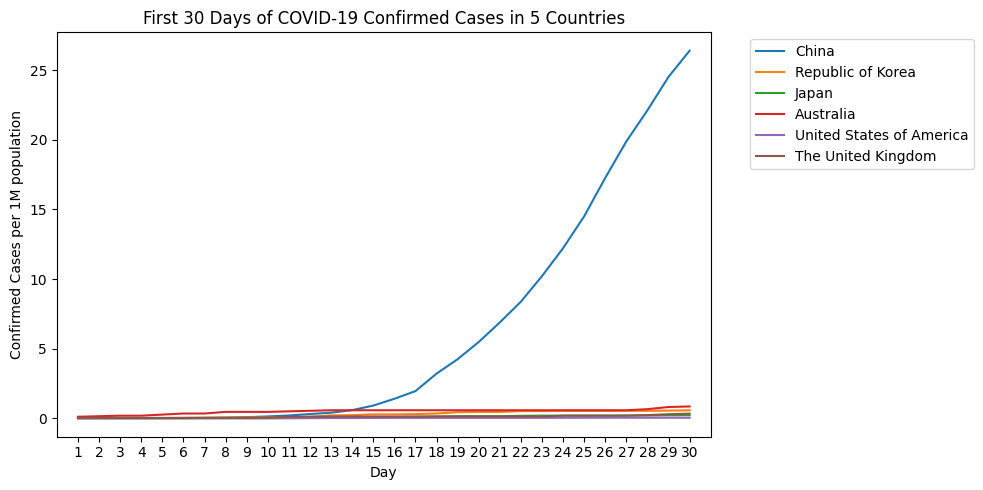

In [27]:
plt.figure(figsize=(10, 5))

x = range(1, 31, 1)
for country in countries:
    rows = df.filter(F.col('Country') == country).collect()
    y = [row.Cumulative_cases_1M for row in rows]
    plt.plot(x, y, label=country)
    
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.xlim(0, 31)
plt.xticks(x)
plt.xlabel('Day')
plt.ylabel('Confirmed Cases per 1M population')
plt.title('First 30 Days of COVID-19 Confirmed Cases in 5 Countries')
plt.tight_layout()
plt.show()

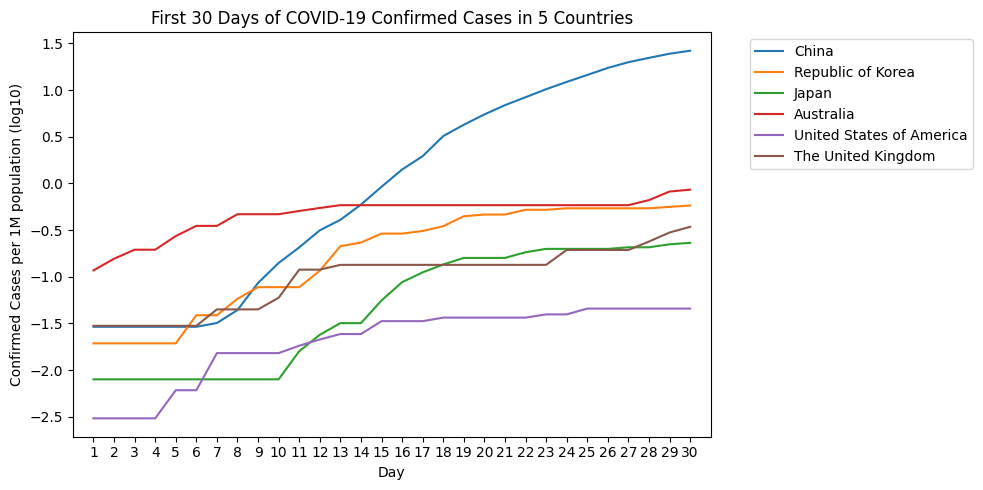

In [28]:
# plot in log10
plt.figure(figsize=(10, 5))

x = range(1, 31, 1)
for country in countries:
    rows = df.filter(F.col('Country') == country).collect()
    y = [np.log10(row.Cumulative_cases_1M) for row in rows]
    plt.plot(x, y, label=country)
    
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.xlim(0, 31)
plt.xticks(x)
plt.xlabel('Day')
plt.ylabel('Confirmed Cases per 1M population (log10)')
plt.title('First 30 Days of COVID-19 Confirmed Cases in 5 Countries')
plt.tight_layout()
plt.show()